# EE613 - Nonlinear Regression II - Exercise 1: Sampling from Prior and Posterior Distribution of GPR

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from scipy.stats import norm as normal_dist

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Declare Parameters 

In [2]:
n_in = 1 #dimension of x
n_out = 1 #dimension of y
n_data = 6 #number of datapoints
n_data_reprod = 100 #number of datapoints in a reproduction

#### Generate Random Data 

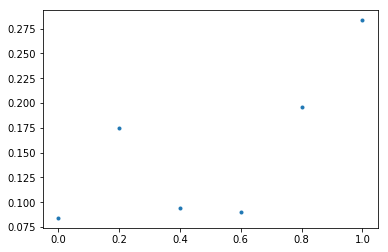

In [3]:
x = np.linspace(0,1,n_data)
y = np.random.rand(n_data)*0.3
data = np.vstack([x,y]).T
plt.plot(x,y,'.')

In [4]:
x_test = np.linspace(0,1,n_data_reprod)

### Question 1: Prior Distribution

- Define a GPR with RBF kernel. Set the parameters by hand.

- Given x_test, calculate the covariance matrix K(x_test, x_test)

- Generate 20 samples of the corresponding output y_test by sampling from the prior distribution of the GPR

- Modify the GPR parameters and see the effect on the prior samples

### Q1 Solution 

#### Define functions for GPR 

In [5]:
def RBF_cov_function(x1,x2,params):
    return params[0] * np.exp(-(norm(x1-x2)**2)/params[1])

def compute_cov_matrix(X1,X2,params, cov_func = RBF_cov_function):
    #You can define other covariance function to replace RBF_cov_function
    n_row = len(X1)
    n_col = len(X2)
    K = np.zeros((n_row, n_col))
    for i in range(n_row):
        for j in range(n_col):
            K[i,j] = cov_func(X1[i], X2[j], params)
            
    return K

#### Compute the GPR parameters (the covariance matrix) 

In [6]:
from numpy.linalg import norm as norm

params = np.array([0.1, 0.1, 1e-4]) #GPR parameters: output scale, input scale and the noise variance
                                    #(here defined for squared exponential kernels and noisy observations)
K = compute_cov_matrix(x,x,params)
K_inv = np.linalg.pinv(K + params[-1]*np.eye(K.shape[0]))

#### Given the input xs, compute the prediction 

In [7]:
xs = x_test.copy() #the input

#Mean computation 
Ks = compute_cov_matrix(xs,x,params)
ys = np.dot(Ks, np.dot(K_inv,y)) # the mean
#Uncertainty evaluation 
Kss = compute_cov_matrix(xs,xs,params)
S = Kss - np.dot(Ks, np.dot(K_inv, Ks.T)) #the covariance

#### Plot Prior Samples 

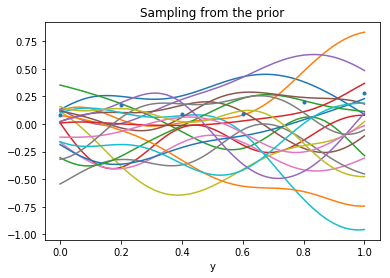

In [8]:
#define the prior distribution
n_reprod = 20
prior_traj_dist = mvn(mean = np.zeros(n_data_reprod), cov=Kss, allow_singular=True)
#sampling from the prior distribution
prior_samples = prior_traj_dist.rvs(size=n_reprod)

for ys_i in prior_samples:
    plt.plot(xs, ys_i)
plt.title('Sampling from the prior')
plt.xlabel('x')
plt.xlabel('y')
plt.plot(x,y,'.')
plt.show()

### Question 2: Posterior Distribution 

- Given the data {x,y}, compute the posterior distribution of y_test that correspond to x_test.

- Generate 20 samples of the output y_test by sampling from the posterior distribution

### Q2 Solution 

#### Plot Posterior Samples 

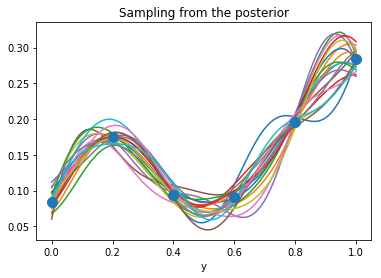

In [11]:
#define the posterior distribution based on the GPR prediction
post_traj_dist = mvn(mean = ys, cov=S, allow_singular=True)
#sampling from the posterior distribution
post_samples = post_traj_dist.rvs(size=n_reprod)

for ys_i in post_samples:
    plt.plot(xs, ys_i)
plt.plot(x,y,'.',markersize=20)
plt.title('Sampling from the posterior')
plt.xlabel('x')
plt.xlabel('y')
plt.show()

### Question 3: Changing the kernel 

In Question 1 and 2, we use RBF kernel. With the same data, use:
- Periodic kernel function
- Polynomial kernel function
- Matern kernel function with $\nu$ = 1/2

Sample from the prior and posterior distributions, and see the difference!

### Q3 Solution 

#### Define the various covariance functions 

In [12]:
def RBF_cov_function(x1,x2,params):
    return params[0] * np.exp(-(norm(x1-x2)**2)/params[1])

def periodic_cov_function(x1,x2,params):
    return params[0] * np.exp(-(np.sin(np.abs(x1-x2)*params[2])**2)/params[1])

def polynomial_cov_function(x1,x2,params):
    x = np.dot(x1,x2)
    return params[0] + x + x**2

def matern_cov_function(x1,x2,params):
    d = np.linalg.norm(x1-x2)
    return (params[0]**2)*np.exp(-d/params[1]) 

#### Given the input xs, compute the prediction 

In [13]:
#rbf params
#params = np.array([0.1, 0.1, 1e-4]) #GPR parameters: output scale, input scale and the noise variance
                                    #(here defined for squared exponential kernels and noisy observations)
#cov_function = RBF_cov_function
    
#periodic params
#params = np.array([0.1,1, 10, 1e-4])
#cov_function = periodic_cov_function

#polynomial params
#params = np.array([0.2,1e-2])
#cov_function = polynomial_cov_function

#matern params
params = np.array([0.1, 3, 1e-4])
cov_function = matern_cov_function
   
    

xs = x_test.copy() #the input

K = compute_cov_matrix(x,x,params,cov_func=cov_function)
K_inv = np.linalg.pinv(K + params[-1]*np.eye(K.shape[0]))

#Mean computation 
Ks = compute_cov_matrix(xs,x,params,cov_func=cov_function)
ys = np.dot(Ks, np.dot(K_inv,y)) # the mean
#Uncertainty evaluation 
Kss = compute_cov_matrix(xs,xs,params,cov_func=cov_function)
S = Kss - np.dot(Ks, np.dot(K_inv, Ks.T)) + np.eye(len(Kss))*1e-7 #the covariance

#### Plot Prior Samples 

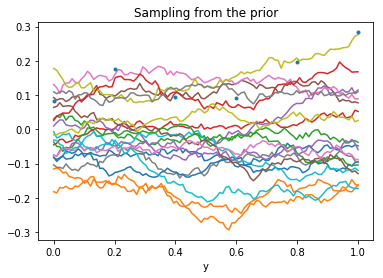

In [14]:
#define the prior distribution
n_reprod = 20
prior_traj_dist = mvn(mean = np.zeros(n_data_reprod), cov=Kss, allow_singular=True)
#sampling from the prior distribution
prior_samples = prior_traj_dist.rvs(size=n_reprod)

for ys_i in prior_samples:
    plt.plot(xs, ys_i)
plt.title('Sampling from the prior')
plt.xlabel('x')
plt.xlabel('y')
plt.plot(x,y,'.')
plt.show()

#### Plot Posterior Samples 

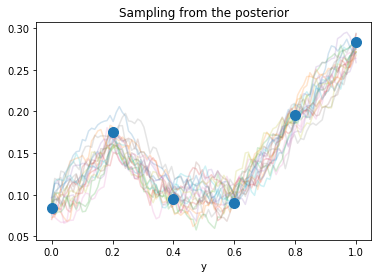

In [15]:
#define the posterior distribution based on the GPR prediction
post_traj_dist = mvn(mean = ys, cov=S, allow_singular=True)
#sampling from the posterior distribution
post_samples = post_traj_dist.rvs(size=n_reprod)

for ys_i in post_samples:
    plt.plot(xs, ys_i,alpha=0.2)
plt.plot(x,y,'.',markersize=20)
plt.title('Sampling from the posterior')
plt.xlabel('x')
plt.xlabel('y')
plt.show()